In [40]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
import cv2

In [13]:
#probabilistic generator parameters
mean = .0
scale = .2

#model meta parameters
lr = .0005

In [16]:
def show(image):
  cv2_imshow(zoom(image*255,8))

In [14]:
def zoom(img, zoom_factor=1.5):
    return cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor,interpolation=0)

In [15]:
def generated_image(mean, stddev, minval, maxval):
  return np.clip(np.random.normal(loc=mean, scale=stddev,size=(28,28)), minval, maxval)

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape, activation='relu'))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(learning_rate=lr, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [34]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
 
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (2,2), strides=(4,4), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [42]:
def generate_data(mean=0, scale=.2, data_size = 100):
  data = []
  labels = []
  for _ in range(data_size):
    data.append(generated_image(mean,scale,0,1))
    labels.append(0)
    data.append(np.random.rand(28,28))
    labels.append(1)
  return (np.array(labels),np.array(data))

In [35]:
g_model = define_generator(100)
g_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 28, 28, 128)      65664     
 Transpose)                                                      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 28, 28, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 1)         6273      
                                                      

1/1 [==============================] - 0s 86ms/step


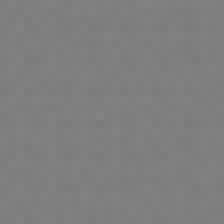

In [36]:
x = np.array([np.random.rand(100)])
out = g_model.predict(x).reshape(28,28)
show(out)

In [46]:
d_model = define_discriminator()
d_model.predict(out.reshape(1,28,28,1))

1/1 [==============================] - 0s 53ms/step


array([[0.50043684]], dtype=float32)

In [47]:
labels,data = generate_data()
valid_labels, valid_data = generate_data(mean=.2,scale=.3,data_size=50)

d_model.build(input_shape = (28,28,1))
history = d_model.fit(x = data, y = labels, epochs=10, validation_data=(valid_data,valid_labels))

Epoch 1/10
7/7 [==============================] - 1s 36ms/step - loss: 0.5910 - accuracy: 0.5400 - val_loss: 0.6740 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 0s 14ms/step - loss: 0.4825 - accuracy: 0.5000 - val_loss: 0.6809 - val_accuracy: 0.5000
Epoch 3/10
7/7 [==============================] - 0s 13ms/step - loss: 0.3944 - accuracy: 0.7500 - val_loss: 0.5512 - val_accuracy: 0.5000
Epoch 4/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2680 - accuracy: 1.0000 - val_loss: 0.4769 - val_accuracy: 0.5000
Epoch 5/10
7/7 [==============================] - 0s 17ms/step - loss: 0.1535 - accuracy: 1.0000 - val_loss: 0.3995 - val_accuracy: 0.5400
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 0.0847 - accuracy: 1.0000 - val_loss: 0.3052 - val_accuracy: 0.9800
Epoch 7/10
7/7 [==============================] - 0s 13ms/step - loss: 0.0515 - accuracy: 1.0000 - val_loss: 0.3111 - val_accuracy: 0.9500
Epoch 8/10
7/7 [===========

In [48]:
d_model.predict(out.reshape(1,28,28,1))

1/1 [==============================] - 0s 21ms/step


array([[0.99880433]], dtype=float32)

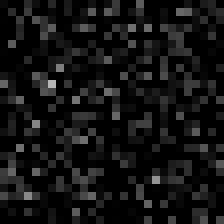

In [49]:
test = generated_image(mean,scale,0,1)
show(test)

In [50]:
d_model.predict(test.reshape(1,28,28,1))

1/1 [==============================] - 0s 18ms/step


array([[0.02130506]], dtype=float32)